In [166]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd
import glob
import os
import tifffile as tiff
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from IPython.display import SVG, HTML, display
from datetime import datetime

## Arauca city

Sentinel-1 imagery

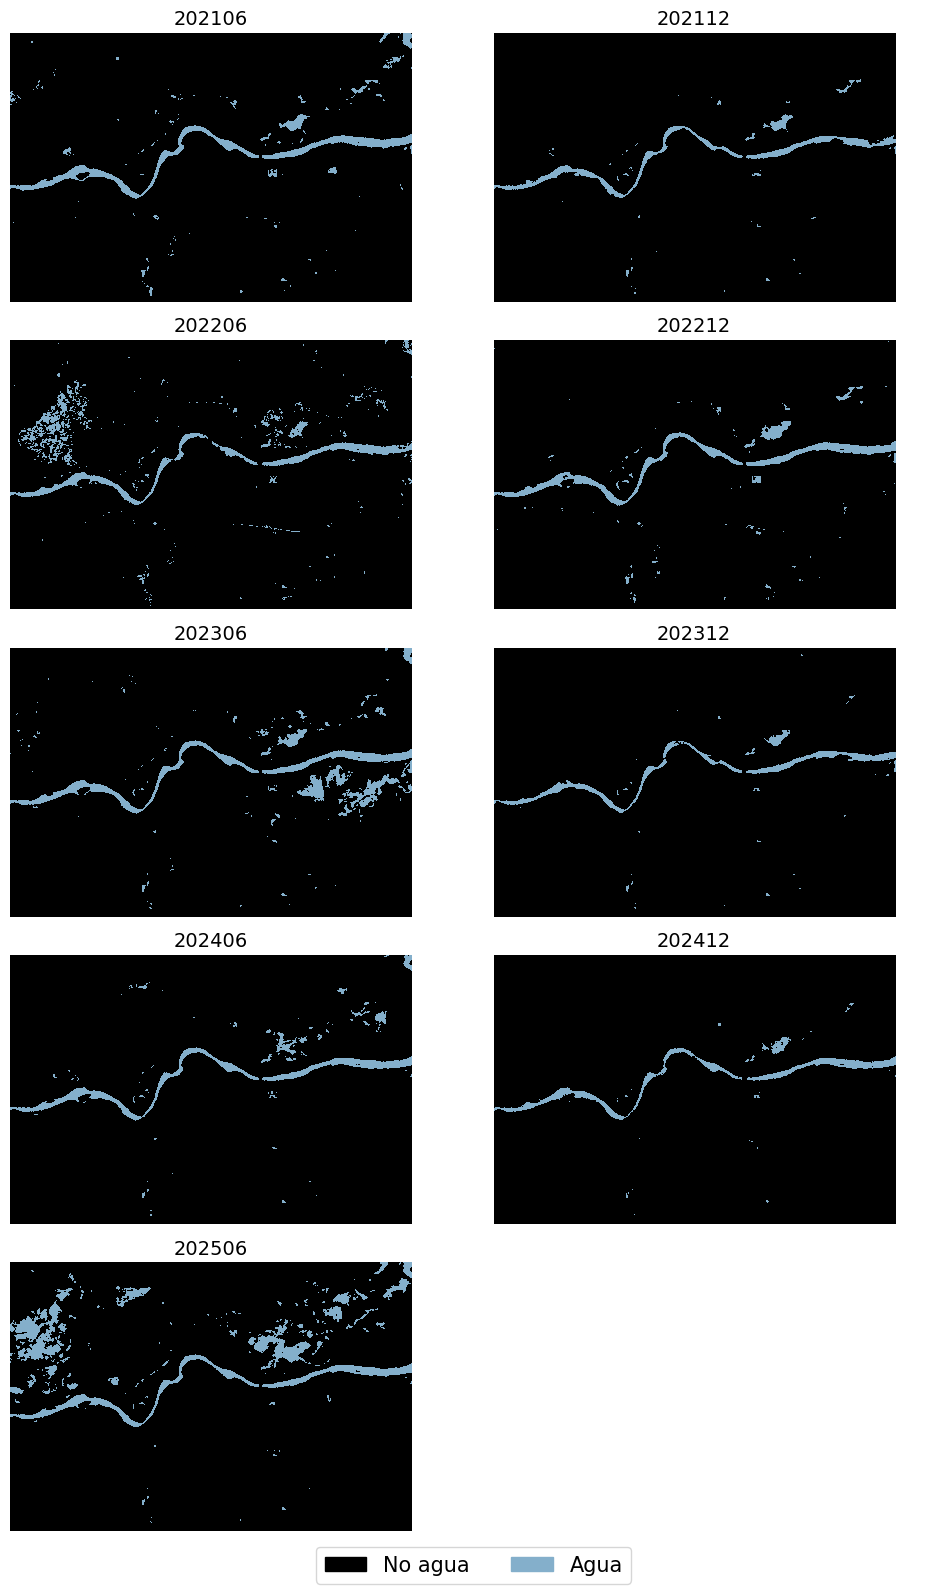

In [97]:
# Path to TIFF files
tiff_files = sorted(glob.glob("./results/aoi_arauca2/water/*.tif"))

# Define custom colors for classes
colors = [
    "black",  # class 0 - (no water)
    "#84AFCB",  # class 1 - (water)
]

cmap = ListedColormap(colors)

fig, axes = plt.subplots(5, 2, figsize=(10, 16))
axes = axes.flatten()

# Loop through images and plot them
for i, file in enumerate(tiff_files):
    img = tiff.imread(file)

    # Extract filename and title
    filename = os.path.basename(file)
    title_text = os.path.splitext(filename)[0][-6:]  

    # Show the image with defined colormap
    axes[i].imshow(img, cmap=cmap)
    axes[i].set_title(title_text, fontsize=14)
    axes[i].axis('off')

# Hide unused axes if fewer than 2 images
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Create legend
legend_labels = ["No agua", "Agua"]
patches = [mpatches.Patch(color=colors[k], label=legend_labels[k]) for k in range(len(colors))]
fig.legend(handles=patches, loc='lower center', ncol=4, fontsize=15, frameon=True)

plt.tight_layout(rect=[0, 0.03, 1, 1])  
plt.show()


In [ ]:
# Folder with all TIFF files
tiff_files = sorted(glob.glob("./results/aoi_arauca2/water/*.tif"))

for raster_path in tiff_files:
    with rasterio.open(raster_path) as src:
        dst_crs = "EPSG:32619"  # Target CRS (UTM 19N)

        # Compute transform, width, and height for reprojection
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )

        # Prepare metadata for reprojected raster
        kwargs = src.meta.copy()
        kwargs.update({
            "crs": dst_crs,
            "transform": transform,
            "width": width,
            "height": height
        })

        # Allocate empty array for reprojected data
        dst_array = np.empty((height, width), dtype=src.meta["dtype"])

        # Reproject
        reproject(
            source=rasterio.band(src, 1),
            destination=dst_array,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

        # Pixel area (in m², since UTM is in meters)
        pixel_size_x, pixel_size_y = abs(transform[0]), abs(transform[4])
        pixel_area = pixel_size_x * pixel_size_y

        # Compute unique classes and their pixel counts
        unique, counts = np.unique(dst_array, return_counts=True)

        # Convert to areas
        areas_m2 = counts * pixel_area
        areas_km2 = areas_m2 / 1e6

        # Organize results
        df = pd.DataFrame({
            "Class": unique,
            "Pixel_count": counts,
            "Area_m2": areas_m2,
            "Area_km2": areas_km2
        })

        # Print results per file
        print(f"{os.path.basename(raster_path[-10:])}")
        print(f"epsg: {src.crs}, pixel size: {pixel_size_x} x {pixel_size_y} m, pixel area: {pixel_area} m²")
        print(df)


202106.tif
epsg: EPSG:4326, pixel size: 9.928024067829066 x 9.928024067829066 m, pixel area: 98.56566189139319 m²
   Class  Pixel_count       Area_m2    Area_km2
0      0      1235518  1.217796e+08  121.779649
1      1        45573  4.491933e+06    4.491933
202112.tif
epsg: EPSG:4326, pixel size: 9.928024067829066 x 9.928024067829066 m, pixel area: 98.56566189139319 m²
   Class  Pixel_count       Area_m2    Area_km2
0      0      1250875  1.232933e+08  123.293322
1      1        30216  2.978260e+06    2.978260
202206.tif
epsg: EPSG:4326, pixel size: 9.928024067829066 x 9.928024067829066 m, pixel area: 98.56566189139319 m²
   Class  Pixel_count       Area_m2    Area_km2
0      0      1221201  1.203685e+08  120.368485
1      1        59890  5.903097e+06    5.903097
202212.tif
epsg: EPSG:4326, pixel size: 9.928024067829066 x 9.928024067829066 m, pixel area: 98.56566189139319 m²
   Class  Pixel_count       Area_m2    Area_km2
0      0      1239860  1.222076e+08  122.207622
1      1        

Water cover area

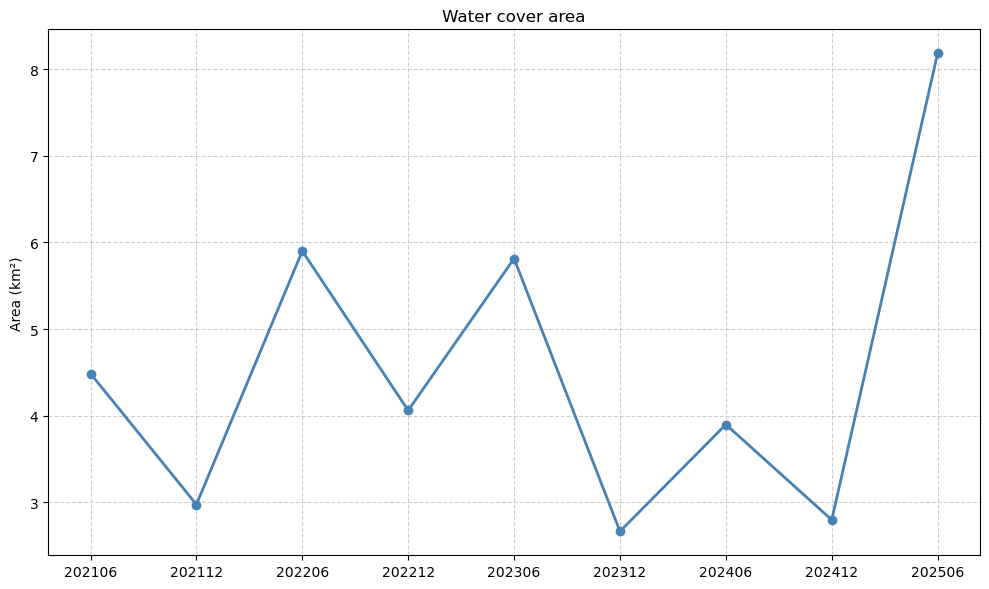

In [146]:
# Get all CSV files
csv_files = glob.glob("./results/aoi_arauca2/water-cover/*.csv")

labels = []
areas_km2 = []

for file in csv_files:
    filename = os.path.basename(file)
    label = os.path.splitext(filename)[0][:6]
    
    df = pd.read_csv(file)
    df['1'] = pd.to_numeric(df['1'].astype(str).str.replace(',', ''))
    
    # Convert from m² to km²
    area_km2 = df['1'].iloc[0] / 1e6
    
    labels.append(label)
    areas_km2.append(area_km2)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(labels, areas_km2, marker='o', color='steelblue', linewidth=2)
plt.title("Water cover area")
plt.ylabel("Area (km²)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [148]:
# Basic stats 
max_value = max(areas_km2)
min_value = min(areas_km2)
max_label = labels[areas_km2.index(max_value)]
min_label = labels[areas_km2.index(min_value)]

print(f"Área máxima: {max_value:.2f} km² ({max_label})")
print(f"Área mínima: {min_value:.2f} km² ({min_label})")

# --- Filtrar valores de junio (06) y diciembre (12) ---
june_values = [area for label, area in zip(labels, areas_km2) if label.endswith("06")]
dec_values  = [area for label, area in zip(labels, areas_km2) if label.endswith("12")]

mean_june = np.mean(june_values)
std_june = np.std(june_values, ddof=1)  # ddof=1 para muestra
print(f"Media junio: {mean_june:.2f} km²")
print(f"Desviación estándar junio: {std_june:.2f} km²")

mean_dec = np.mean(dec_values)
std_dec = np.std(dec_values, ddof=1)
print(f"Media diciembre: {mean_dec:.2f} km²")
print(f"Desviación estándar diciembre: {std_dec:.2f} km²")


Área máxima: 8.18 km² (202506)
Área mínima: 2.67 km² (202312)
Media junio: 5.66 km²
Desviación estándar junio: 1.65 km²
Media diciembre: 3.13 km²
Desviación estándar diciembre: 0.64 km²


Precipitation

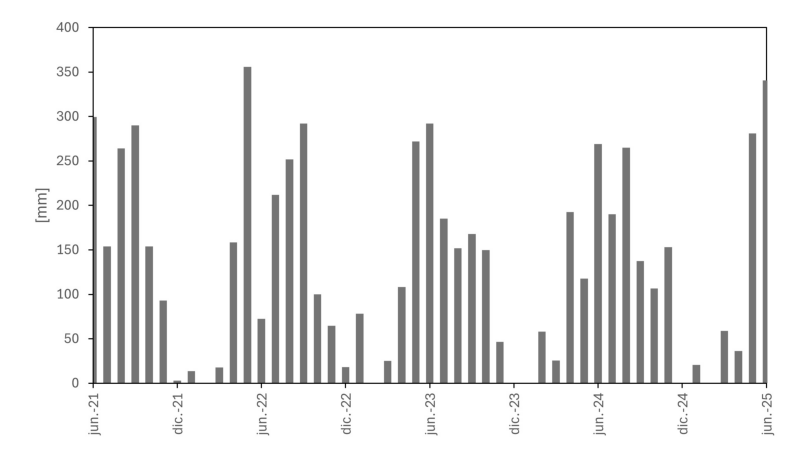

In [32]:
img = mpimg.imread('./data/arauca/precip_ara/2021-2025.jpg')
# Display smaller
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis("off")
plt.show()

Validation - OPERA dataset

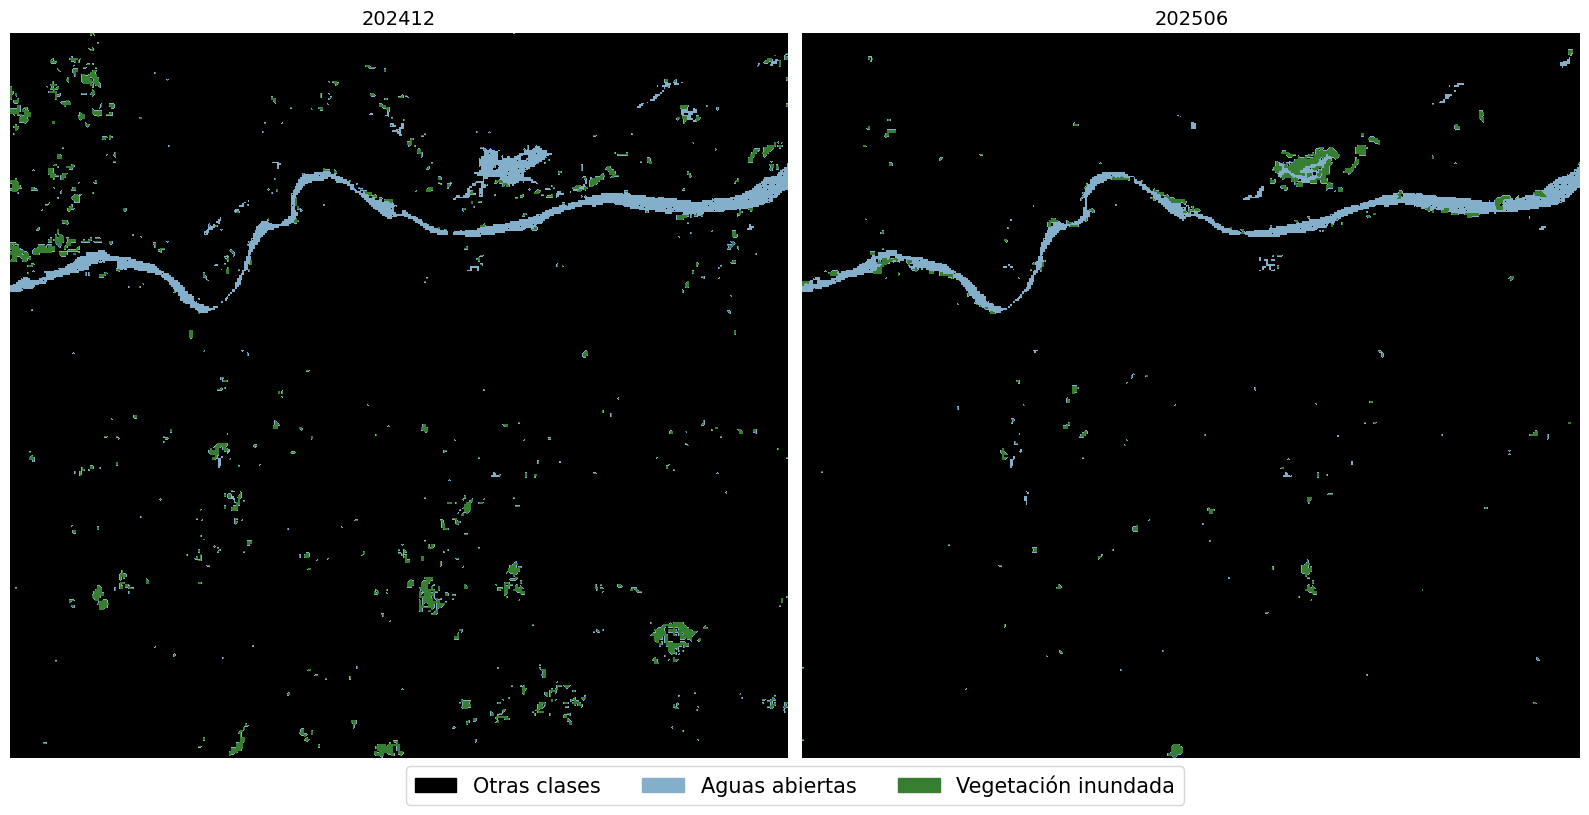

In [149]:
# Path to TIFF files
tiff_files = sorted(glob.glob("./data/opera/*.tif"))

# Define custom colors for classes
colors = [
    "black",  # class 0 - black (other/background)
    "#84AFCB",  # class 1 - blue (open water)
    "#377f30",  # class 2 - green (inundated vegetation)
]

cmap = ListedColormap(colors)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes = axes.flatten()

# Loop through images and plot them
for i, file in enumerate(tiff_files):
    img = tiff.imread(file)

    # Extract filename and title
    filename = os.path.basename(file)
    title_text = os.path.splitext(filename)[0][:6]  

    # Show the image with defined colormap
    axes[i].imshow(img, cmap=cmap)
    axes[i].set_title(title_text, fontsize=14)
    axes[i].axis('off')

# Hide unused axes if fewer than 2 images
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Create legend
legend_labels = ["Otras clases", "Aguas abiertas", "Vegetación inundada"]
patches = [mpatches.Patch(color=colors[k], label=legend_labels[k]) for k in range(len(colors))]
fig.legend(handles=patches, loc='lower center', ncol=4, fontsize=15, frameon=True)

plt.tight_layout(rect=[0, 0.05, 1, 1])  
plt.show()

In [152]:
# Path to your raster
raster_path = "./data/opera/20241218_WTR_clip.tif"

with rasterio.open(raster_path) as src:
    img = src.read(1)  # Read first band
    pixel_size_x, pixel_size_y = src.res  # Resolution (in meters)
    pixel_area = abs(pixel_size_x * pixel_size_y)  # Area of each pixel (m²)
    print(f"epsg: {src.crs}, pixel size: {pixel_size_x} x {pixel_size_y} m, pixel area: {pixel_area} m²")

# Calculate unique classes and their pixel counts
unique, counts = np.unique(img, return_counts=True)

# Convert pixel counts to area 
areas_m2 = counts * pixel_area
areas_km2 = areas_m2 / 1e6

# Organize results in a table 
df = pd.DataFrame({
    "Class": unique,
    "Pixel_count": counts,
    "Area_m2": areas_m2,
    "Area_km2": areas_km2
})

print(df)

epsg: EPSG:32619, pixel size: 30.0 x 30.0 m, pixel area: 900.0 m²
   Class  Pixel_count      Area_m2  Area_km2
0      0       178679  160811100.0  160.8111
1      1         4676    4208400.0    4.2084
2      3         3044    2739600.0    2.7396


In [154]:
# Path to your raster
raster_path = "./data/opera/20250616_WTR_clip.tif"

with rasterio.open(raster_path) as src:
    img = src.read(1)  # Read first band
    pixel_size_x, pixel_size_y = src.res  # Resolution (in meters)
    pixel_area = abs(pixel_size_x * pixel_size_y)  # Area of each pixel (m²)
    print(f"epsg: {src.crs}, pixel size: {pixel_size_x} x {pixel_size_y} m, pixel area: {pixel_area} m²")

# Calculate unique classes and their pixel counts
unique, counts = np.unique(img, return_counts=True)

# Convert pixel counts to area 
areas_m2 = counts * pixel_area
areas_km2 = areas_m2 / 1e6

# Organize results in a table 
df = pd.DataFrame({
    "Class": unique,
    "Pixel_count": counts,
    "Area_m2": areas_m2,
    "Area_km2": areas_km2
})

print(df)

epsg: EPSG:32619, pixel size: 30.0 x 30.0 m, pixel area: 900.0 m²
   Class  Pixel_count      Area_m2  Area_km2
0      0       181374  163236600.0  163.2366
1      1         3768    3391200.0    3.3912
2      3         1257    1131300.0    1.1313
